<a href="https://colab.research.google.com/github/VirtueZhao/Dive_into_Deep_Learning/blob/main/8_1_Sequence_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import d2l
import torch
from torch import nn

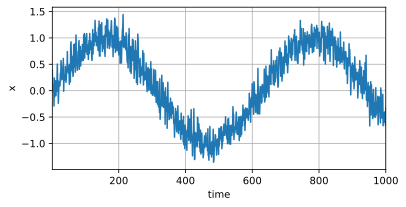

In [2]:
T = 1000
time = torch.arange(1, T + 1, dtype=torch.float32)
# print(time)
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,))
d2l.plot(time, [x], 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

In [11]:
tau = 4
features = torch.zeros((T - tau, tau))
print(features.shape)
print(x.shape)
print(x[:8])
for i in range(tau):
  features[:, i] = x[i:T - tau + i]
print(features[:5])
labels = x[tau:].reshape((-1, 1))
print(labels.shape)
print(labels[:5])
batch_size, n_train = 16, 600
train_iter = d2l.load_array((features[:n_train], labels[:n_train]), batch_size, is_train=True)

torch.Size([996, 4])
torch.Size([1000])
tensor([ 0.3903,  0.0452,  0.0242, -0.0104,  0.1090, -0.2905,  0.2398, -0.1229])
tensor([[ 0.3903,  0.0452,  0.0242, -0.0104],
        [ 0.0452,  0.0242, -0.0104,  0.1090],
        [ 0.0242, -0.0104,  0.1090, -0.2905],
        [-0.0104,  0.1090, -0.2905,  0.2398],
        [ 0.1090, -0.2905,  0.2398, -0.1229]])
torch.Size([996, 1])
tensor([[ 0.1090],
        [-0.2905],
        [ 0.2398],
        [-0.1229],
        [ 0.1906]])


In [12]:
def init_weights(m):
  if type(m) == nn.Linear:
    nn.init.xavier_uniform_(m.weight)


def get_net():
  net = nn.Sequential(
      nn.Linear(4, 10),
      nn.ReLU(),
      nn.Linear(10, 1))
  net.apply(init_weights)
  return net

loss = nn.MSELoss(reduction='none')

In [19]:
def train(net, train_iter, loss, epochs, lr):
  trainer = torch.optim.Adam(net.parameters(), lr)
  for epoch in range(epochs):
    for X, y in train_iter:
      trainer.zero_grad()
      l = loss(net(X), y)
      l.sum().backward()
      trainer.step()
    print(f'epoch {epoch + 1}, '
          f'loss: {d2l.evaluate_loss(net, train_iter, loss):f}')
    

net = get_net()
train(net, train_iter, loss, 5, 0.01)

epoch 1, loss: 0.053221
epoch 2, loss: 0.052040
epoch 3, loss: 0.051167
epoch 4, loss: 0.049906
epoch 5, loss: 0.047380


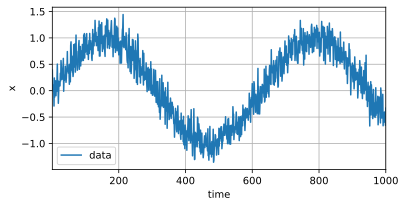

In [20]:
onestep_preds = net(features)
d2l.plot([time], [x.detach().numpy()], 'time', 'x', legend=['data'], xlim=[1, 1000], figsize=(6,3))

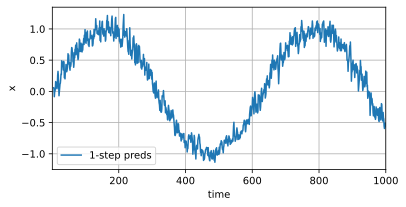

In [21]:
d2l.plot([time[tau:]], [onestep_preds.detach().numpy()], 'time', 'x', legend=['1-step preds'], xlim=[1, 1000], figsize=(6,3))

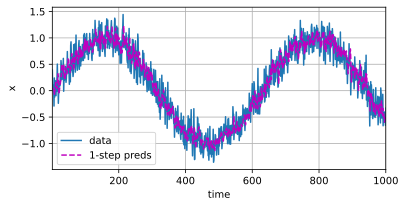

In [22]:
d2l.plot([time, time[tau:]], [x.detach().numpy(), onestep_preds.detach().numpy()], 'time', 'x', legend=['data', '1-step preds'], xlim=[1, 1000], figsize=(6, 3))

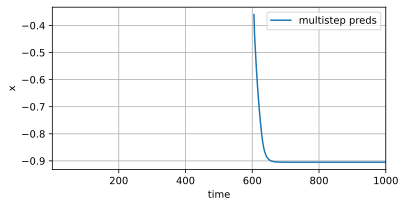

In [23]:
multistep_preds = torch.zeros(T)
multistep_preds[:n_train + tau] = x[: n_train + tau]
for i in range(n_train + tau, T):
  multistep_preds[i] = net(multistep_preds[i - tau:i].reshape((1, -1)))


d2l.plot([time[n_train + tau:]], [multistep_preds[n_train + tau:].detach().numpy()],'time', 'x', legend=['multistep preds'], xlim=[1,1000], figsize=(6,3))

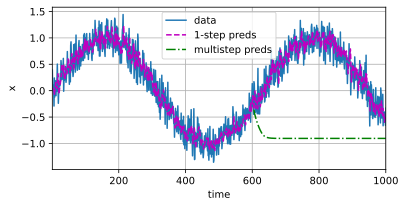

In [27]:
multistep_preds = torch.zeros(T)
multistep_preds[: n_train + tau] = x[: n_train + tau]
for i in range(n_train + tau, T):
    multistep_preds[i] = net(
        multistep_preds[i - tau:i].reshape((1, -1)))

d2l.plot([time, time[tau:], time[n_train + tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy(),
          multistep_preds[n_train + tau:].detach().numpy()], 'time',
         'x', legend=['data', '1-step preds', 'multistep preds'],
         xlim=[1, 1000], figsize=(6, 3))

torch.Size([933, 68])
torch.Size([933, 68])
torch.Size([933, 68])


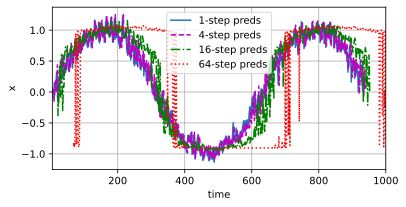

In [42]:
max_steps = 64
features = torch.zeros((T - tau - max_steps + 1, tau + max_steps))
print(features.shape)

for i in range(tau):
  features[:, i] = x[i:i + T - tau - max_steps + 1]
print(features.shape)

for i in range(tau, tau + max_steps):
  features[:, i] = net(features[:, i - tau:i]).reshape(-1)
print(features.shape)

steps = (1, 4, 16, 64)
d2l.plot([time[tau + i - 1: T - max_steps + i] for i in steps],
         [features[:, (tau + i - 1)].detach().numpy() for i in steps], 'time', 'x',
         legend=[f'{i}-step preds' for i in steps], xlim=[5, 1000],
         figsize=(6,3))